# Simple Neural Network

Neural Networks are a machine learning framework that attempts to mimic the learning pattern of natural biological neural networks. neural networks receive inputs, then based on these inputs they produce an output signal to next. The process of creating a neural network begins with the most basic form, a single perceptron or Multi layer Perceptron.

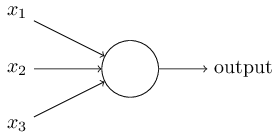

It takes several input, processes it through multiple neurons from multiple hidden layers and returns the result using an output layer. This result estimation process is technically known as “Forward Propagation“.

Next, we compare the result with actual output. The task is to make the output to neural network as close to actual (desired) output. Each of these neurons are contributing some error to final output. 

We try to minimize the value/ weight of neurons those are contributing more to the error and this happens while traveling back to the neurons of the neural network and finding where the error lies. This process is known as “Backward Propagation“. .

In order to reduce these number of iterations to minimize the error, the neural networks use a common algorithm known as “Gradient Descent”, which helps to optimize the task quickly and efficiently.

In [2]:
from datetime import datetime
import numpy as np
import numpy as numpy
import pandas as pd
import pylab
import calendar
from scipy import stats
import seaborn as sns
from sklearn import model_selection, preprocessing
from scipy.stats import kendalltau
import warnings
import matplotlib.pyplot as plt
import pandas

from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout, BatchNormalization
from keras.layers.advanced_activations import PReLU
from keras.optimizers import Adam
from keras.wrappers.scikit_learn import KerasRegressor
from keras import callbacks
from keras.callbacks import ModelCheckpoint

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import mean_squared_error

import patsy
import statsmodels.api as sm
import statsmodels.formula.api as smf
from statsmodels.regression.quantile_regression import QuantReg


C:\Users\Reshma.nspr\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
C:\Users\Reshma.nspr\Anaconda3\lib\site-packages\statsmodels\compat\pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [3]:
# Load train, Prop and sample
print('Loading train, prop and sample data')
train = pd.read_csv("train_2016_v2.csv", parse_dates=["transactiondate"])
prop = pd.read_csv('properties_2016.csv')
sample = pd.read_csv('sample_submission.csv')

Loading train, prop and sample data


C:\Users\Reshma.nspr\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:2785: DtypeWarning: Columns (22,32,34,49,55) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


#### Label Encoder
LabelEncoder is a utility class to help normalize labels categorical values and to encode  such that they contain only values between 0 and n_classes-1. 

Here, we LabelEncode the properties dataset. 

In [4]:
print('Fitting Label Encoder on properties')
for c in prop.columns:
    prop[c]=prop[c].fillna(-1)
    if prop[c].dtype == 'object':
        lbl = LabelEncoder()
        lbl.fit(list(prop[c].values))
        prop[c] = lbl.transform(list(prop[c].values))

Fitting Label Encoder on properties


###### Create Test and Train sets

In [5]:
#Create df_train and x_train y_train from that
print('Creating training set')
df_train = train.merge(prop, how='left', on='parcelid')

Creating training set


In [6]:
# Create df_test and test set
print('Creating df_test')
sample['parcelid'] = sample['ParcelId']

Creating df_test


In [7]:
print("Merge Sample with property data")
df_test = sample.merge(prop, on='parcelid', how='left')

Merge Sample with property data


In [8]:
INCLUDE_TIME_FEATURES = False
INCLUDE_SEASONAL_FEATURES = True
N_EPOCHS = 150
BEST_EPOCH = False
CV_ONLY = False

###### Q4 Validation

Here, we divide the whole year is didvided into four quarters (q1,q2,q3,q4) and the first three quaters are considered to be part of traning set and the validation set has the last qurater q4, Hence Q4 Validation.

The quarters are divided based on the time and seasonal features. With the help of error in the Q4 validation set between it's existing Log Error and predicted Log Error it uses backpropagation in each Epoch to minimize it and build a better model.

In [9]:
df_train["transactiondate"] = pd.to_datetime(df_train["transactiondate"])
df_train['transactiondate_quarter'] = df_train['transactiondate'].dt.quarter
if INCLUDE_TIME_FEATURES:
    df_train["transactiondate_year"] = df_train["transactiondate"].dt.year
    df_train["transactiondate_month"] = df_train["transactiondate"].dt.month
    df_train["transactiondate"] = df_train["transactiondate"].dt.day
if INCLUDE_SEASONAL_FEATURES:
    basedate = pd.to_datetime('2015-11-15').toordinal()
    df_train['cos_season'] = \
        ( (pd.to_datetime(df_train['transactiondate']).apply(lambda x: x.toordinal()-basedate)) * \
          (2*np.pi/365.25) ).apply(np.cos)
    df_train['sin_season'] = \
        ( (pd.to_datetime(df_train['transactiondate']).apply(lambda x: x.toordinal()-basedate)) * \
          (2*np.pi/365.25) ).apply(np.sin)

    
select_qtr4 = df_train["transactiondate_quarter"] == 4

print('Create x_train and y_train from df_train' )
x_train_all = df_train.drop(['parcelid', 'logerror', 'transactiondate', 'propertyzoningdesc', 'propertycountylandusecode',
                             'fireplacecnt', 'fireplaceflag'], axis=1)


Create x_train and y_train from df_train
(81733, 55) (81733,)


In [ ]:
if not INCLUDE_TIME_FEATURES:
     x_train_all = x_train_all.drop(['transactiondate_quarter'], axis=1)

y_train_all = df_train["logerror"]
y_train = y_train_all[~select_qtr4]
x_train = x_train_all[~select_qtr4]
x_valid = x_train_all[select_qtr4]
y_valid = y_train_all[select_qtr4]

y_mean = np.mean(y_train)
print(x_train.shape, y_train.shape)
train_columns = x_train.columns

for c in x_train.dtypes[x_train.dtypes == object].index.values:
    x_train[c] = (x_train[c] == True)

if INCLUDE_TIME_FEATURES:
    df_test["transactiondate"] = pd.to_datetime('2016-11-15')  # typical date for 2016 test data
    df_test["transactiondate_year"] = df_test["transactiondate"].dt.year
    df_test["transactiondate_month"] = df_test["transactiondate"].dt.month
    df_test['transactiondate_quarter'] = df_test['transactiondate'].dt.quarter
    df_test["transactiondate"] = df_test["transactiondate"].dt.day 
if INCLUDE_SEASONAL_FEATURES:
    basedate = pd.to_datetime('2015-11-15').toordinal()
    df_test['cos_season'] = np.cos( (pd.to_datetime('2016-11-15').toordinal() - basedate) * \
                                    (2*np.pi/365.25) )
    df_test['sin_season'] = np.sin( (pd.to_datetime('2016-11-15').toordinal() - basedate) * \
                                    (2*np.pi/365.25) )

In [10]:
x_test = df_test[train_columns]

print('Shape of x_test:', x_test.shape)
print("Preparing x_test:")
for c in x_test.dtypes[x_test.dtypes == object].index.values:
    x_test[c] = (x_test[c] == True)

Shape of x_test: (2985217, 55)
Preparing x_test:


###### Imputer 
Imputation transformer is used for completing missing values.

In [11]:
from sklearn.preprocessing import Imputer
imputer= Imputer()
imputer.fit(x_train.iloc[:, :])
x_train = imputer.transform(x_train.iloc[:, :])
imputer.fit(x_valid.iloc[:, :])
x_valid = imputer.transform(x_valid.iloc[:, :])
imputer.fit(x_test.iloc[:, :])
x_test = imputer.transform(x_test.iloc[:, :])

##### Standard Scalar

Standardizes features by removing the mean and scaling to unit variance

Centering and scaling happen independently on each feature by computing the relevant statistics on the samples in the training set. Mean and standard deviation are then stored to be used on later data using the transform method.

Standardization of a dataset is a common requirement for many machine learning estimators: they might behave badly if the individual feature do not more or less look like standard normally distributed data (e.g. Gaussian with 0 mean and unit variance)

In [12]:
sc = StandardScaler()
x_train = sc.fit_transform(x_train)
x_test = sc.transform(x_test)
x_valid = sc.fit_transform(x_valid)
x_val = np.array(x_valid)
y_val = np.array(y_valid)

###### Train Network
Here we have five layered Neural network with inputs to the network 
starting from 400 to 1.
###### Kernel Initializers
Initializations define the way to set the initial random weights of Keras layers.
##### Random Normal Initializer
Initializer that generates tensors with a normal distribution.
###### Batch Normalization
We normalize the input layer by adjusting and scaling the activations and to speed up learning. In Batch normalization the output of a previous activation layer by subtracting the batch mean and dividing by the batch standard deviation.

However, after this shift/scale of activation outputs by some randomly initialized parameters, the weights in the next layer are no longer optimal. GD (gradient descent) undoes this normalization if it’s a way for it to minimize the loss function.

Here, we use mean absolute error loss function and Adam optimizer.

In [13]:
len_x=int(x_train.shape[1])
print("len_x is:",len_x)

nn = Sequential()
nn.add(Dense(units = 400 , kernel_initializer = 'normal', input_dim = len_x))
nn.add(PReLU())
nn.add(Dropout(.4))
nn.add(Dense(units = 160 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.6))
nn.add(Dense(units = 64 , kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.5))
nn.add(Dense(units = 26, kernel_initializer = 'normal'))
nn.add(PReLU())
nn.add(BatchNormalization())
nn.add(Dropout(.6))
nn.add(Dense(1, kernel_initializer='normal'))

nn.compile(loss='mae', optimizer='Adam')

nn.fit(np.array(x_train), np.array(y_train), batch_size = 32, epochs = N_EPOCHS, verbose=2, 
       validation_data=(x_val,y_val))

valid_pred = nn.predict(x_val)

len_x is: 55
Train on 81733 samples, validate on 8542 samples
Epoch 1/150
 - 30s - loss: 0.0760 - val_loss: 0.0666
Epoch 2/150
 - 14s - loss: 0.0693 - val_loss: 0.0662
Epoch 3/150
 - 14s - loss: 0.0686 - val_loss: 0.0655
Epoch 4/150
 - 14s - loss: 0.0683 - val_loss: 0.0656
Epoch 5/150
 - 14s - loss: 0.0682 - val_loss: 0.0657
Epoch 6/150
 - 14s - loss: 0.0682 - val_loss: 0.0657
Epoch 7/150
 - 14s - loss: 0.0681 - val_loss: 0.0654
Epoch 8/150
 - 14s - loss: 0.0681 - val_loss: 0.0658
Epoch 9/150
 - 13s - loss: 0.0681 - val_loss: 0.0654
Epoch 10/150
 - 14s - loss: 0.0681 - val_loss: 0.0657
Epoch 11/150
 - 14s - loss: 0.0680 - val_loss: 0.0662
Epoch 12/150
 - 14s - loss: 0.0680 - val_loss: 0.0654
Epoch 13/150
 - 13s - loss: 0.0680 - val_loss: 0.0654
Epoch 14/150
 - 13s - loss: 0.0680 - val_loss: 0.0657
Epoch 15/150
 - 13s - loss: 0.0679 - val_loss: 0.0658
Epoch 16/150
 - 14s - loss: 0.0679 - val_loss: 0.0661
Epoch 17/150
 - 14s - loss: 0.0679 - val_loss: 0.0665
Epoch 18/150
 - 13s - loss: 0

In [14]:
rmse = np.sqrt(mean_squared_error(y_val,valid_pred))
print('Test RMSE: %.3f' % rmse)

Test RMSE: 0.148


###### Predict and Write Results

In [15]:

if not CV_ONLY:
    print("\nGenerating predictions...")
    y_pred_ann = nn.predict(x_test)

    print( "\nPreparing results for write..." )
    y_pred = y_pred_ann.flatten()

    output = pd.DataFrame({'ParcelId': prop['parcelid'].astype(np.int32),
            '201610': y_pred, '201611': y_pred, '201612': y_pred,
            '201710': y_pred, '201711': y_pred, '201712': y_pred})
    # set col 'ParceID' to first col
    cols = output.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    output = output[cols]

    print( "\nWriting results to disk:" )
    output.to_csv('Only_ANN_{}.csv'.format(datetime.now().strftime('%Y%m%d_%H%M%S')), index=False)



print( "\nFinished!" )


Generating predictions...

Preparing results for write...

Writing results to disk:

Finished!


# Summary:

In this notebook, we have implemented Simple neural networks with 5 layers for  prediction of LogError = (log(Zestimate)-log(salesprice)) using 2016 property dataset and its corresponding log error values provided by zillow for home value prediction in Python using Keras and tensorflow deep learning libraries.

Original dataset is prepared accordingly and required features are label encoded rest of the features which are almost zero or few are dropped. Later,the whole year is didvided into four quarters and the first three quaters are considered to be part of traning set and the validation set has the last qurater q4, Hence Q4 Validation.

The quarters are divided based on the time and seasonal features. With the help of error in the Q4 validation set between it's existing Log Error and predicted Log Error it uses backpropagation in each Epoch to minimize it and build a better model.

Finally, we have predicted logerror values of 2016 and 2017 for the last quarter (from November to December) in the test dataset and the results are written to a csv file.
Calculate RMSE for the Network built can be seen as 0.148 which means that there is minimal error in the logerror gives us the better predictions.Further, the model can improvised by add more layers or changing the backpropagation parameters.


###### Referrence:

https://www.sciencedirect.com/science/article/pii/S0377221703005484
